## EMOTION DETECTION

### IMPORTING LIBRARIES

In [1]:
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy

In [2]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


In [3]:
data_dir = '/kaggle/input/fer2013'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'test']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=4) for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

In [4]:
print(class_names)

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [5]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

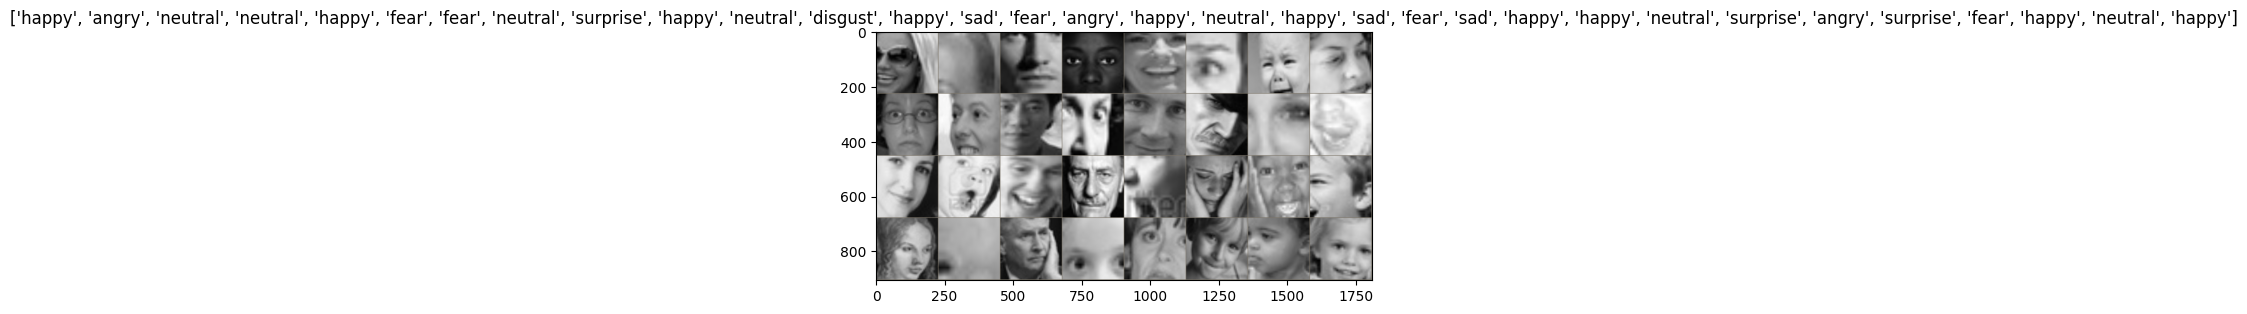

In [6]:
inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [7]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 141MB/s] 


In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_ft = model_ft.to(device)

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


In [ ]:
from tqdm import tqdm  # Import tqdm


def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # Use tqdm for the dataloader to show a progress bar
            for inputs, labels in tqdm(dataloaders[phase], desc=f'{phase} Epoch {epoch+1}/{num_epochs}'):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best test Acc: {best_acc:.4f}')

    model.load_state_dict(best_model_wts)
    return model

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


train Epoch 1/25: 100%|██████████| 898/898 [00:59<00:00, 15.04it/s]


train Loss: 1.5472 Acc: 0.3897


test Epoch 1/25: 100%|██████████| 225/225 [00:13<00:00, 17.04it/s]


test Loss: 1.2220 Acc: 0.5315

Epoch 1/24
----------


train Epoch 2/25: 100%|██████████| 898/898 [00:57<00:00, 15.56it/s]


train Loss: 1.3462 Acc: 0.4828


test Epoch 2/25: 100%|██████████| 225/225 [00:08<00:00, 27.29it/s]


test Loss: 1.1327 Acc: 0.5772

Epoch 2/24
----------


train Epoch 3/25: 100%|██████████| 898/898 [00:57<00:00, 15.50it/s]


train Loss: 1.2760 Acc: 0.5116


test Epoch 3/25: 100%|██████████| 225/225 [00:08<00:00, 26.93it/s]


test Loss: 1.0518 Acc: 0.6021

Epoch 3/24
----------


train Epoch 4/25: 100%|██████████| 898/898 [00:57<00:00, 15.49it/s]


train Loss: 1.2226 Acc: 0.5344


test Epoch 4/25: 100%|██████████| 225/225 [00:08<00:00, 27.63it/s]


test Loss: 1.0320 Acc: 0.6099

Epoch 4/24
----------


train Epoch 5/25: 100%|██████████| 898/898 [00:58<00:00, 15.46it/s]


train Loss: 1.1910 Acc: 0.5460


test Epoch 5/25: 100%|██████████| 225/225 [00:08<00:00, 27.13it/s]


test Loss: 1.0148 Acc: 0.6252

Epoch 5/24
----------


train Epoch 6/25: 100%|██████████| 898/898 [00:57<00:00, 15.49it/s]


train Loss: 1.1561 Acc: 0.5626


test Epoch 6/25: 100%|██████████| 225/225 [00:08<00:00, 26.76it/s]


test Loss: 0.9629 Acc: 0.6422

Epoch 6/24
----------


train Epoch 7/25:  47%|████▋     | 425/898 [00:27<00:30, 15.64it/s]

In [ ]:
torch.save(model_ft.state_dict(), 'best_model.pth')

# Load the model
model_ft.load_state_dict(torch.load('best_model.pth'))
model_ft.eval()


In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

visualize_model(model_ft)
